In [30]:
import pickle

tsdir = '/home/anton/Documents/Tulane/Research/PNC_Good/'
ts = dict(rest=dict(), nback=dict(), emoid=dict())

for task in ['rest', 'nback', 'emoid']:
    tsgood = pickle.load(open(f'{tsdir}/PNC_SPM_{task}_good_filt.pkl', 'rb'))
    ts[task] = tsgood
    
print('Complete')

Complete


In [66]:
import numpy as np
import scipy.signal as sig

# Example
# From https://dsp.stackexchange.com/questions/25165/phase-locking-value-phase-synchronization
def hilphase(y1,y2):
    sig1_hill=sig.hilbert(y1)
    sig2_hill=sig.hilbert(y2)
    pdt=(np.inner(sig1_hill,np.conj(sig2_hill))/(np.sqrt(np.inner(sig1_hill,
               np.conj(sig1_hill))*np.inner(sig2_hill,np.conj(sig2_hill)))))
    phase = np.angle(pdt)
    
def butter_bandpass(cutoff, fs, order=5):
    normal_cutoff = [cutoff[0], cutoff[1]]
    b, a = sig.butter(order, normal_cutoff, btype='band', analog=False, fs=fs)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = sig.filtfilt(b, a, data)
    return y

tr = 3
    
def plv(ts):
    h = sig.hilbert(ts)
    hc = np.conj(h)
    a = np.inner(h,hc)
    b = np.mean(np.abs(h*hc), axis=-1)
    c = np.outer(b,b)
    return np.angle(a/c)

a,b = np.triu_indices(264,1)
ps = dict()

for key,val in ts['emoid'].items():
#     filt = butter_bandpass_filter(val, [0.01, 0.15], 1/tr)
    test = plv(val)
    ps[key] = test[a,b]
    
print(ps[key].shape)

(34716,)


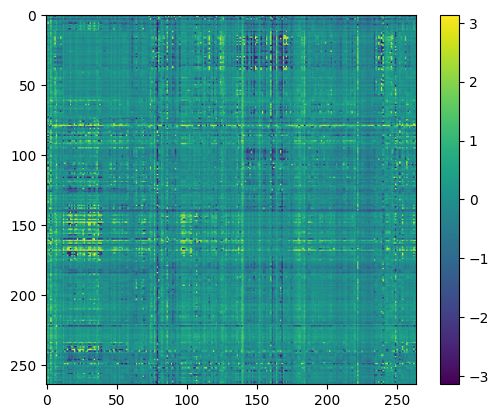

In [67]:
import matplotlib.pyplot as plt

plt.imshow(test)
plt.colorbar()
plt.show()

In [68]:
# Bring in (new) PNC cohort

import pickle
from pathlib import Path
import numpy as np

demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC'
demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

age = []
sex = []
race = []
psvec = []

for key,val in ps.items():
    aa = demo['age_at_cnb'][key]
    psvec.append(val)
    age.append(aa)
    
psvec = np.stack(psvec)
age = np.array(age).astype('int')

print([a.shape for a in [psvec, age]])

[(1500, 34716), (1500,)]


In [72]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

def rmse(yhat, yt):
    if isinstance(yhat, np.ndarray):
        return np.mean((yhat-yt)**2)**0.5

xtr, xt, ytr, yt = train_test_split(psvec, age, train_size=0.8)

reg = Ridge(alpha=1).fit(xtr, ytr)
yhat = reg.predict(xt)
acc = rmse(yhat, yt)
print(acc)

2.7397150427503862
